2025-05-10 12:20:37,769 - INFO - Loaded data from 1996-01-01 to 2025-05-08
2025-05-10 12:20:37,770 - INFO - Calculating statistics from historical price data...
2025-05-10 12:20:37,770 - INFO - Start price: 5.82, End price: 1407.00
2025-05-10 12:20:37,772 - INFO - Mean Daily Return: 0.001401
2025-05-10 12:20:37,772 - INFO - Daily Volatility: 0.047542
2025-05-10 12:20:37,772 - INFO - Annual Return: 0.4232
2025-05-10 12:20:37,773 - INFO - Annual Volatility: 0.7547
2025-05-10 12:20:37,773 - INFO - Running Monte Carlo simulations...
2025-05-10 12:20:37,770 - INFO - Calculating statistics from historical price data...
2025-05-10 12:20:37,770 - INFO - Start price: 5.82, End price: 1407.00
2025-05-10 12:20:37,772 - INFO - Mean Daily Return: 0.001401
2025-05-10 12:20:37,772 - INFO - Daily Volatility: 0.047542
2025-05-10 12:20:37,772 - INFO - Annual Return: 0.4232
2025-05-10 12:20:37,773 - INFO - Annual Volatility: 0.7547
2025-05-10 12:20:37,773 - INFO - Running Monte Carlo simulations...
2025-


Summary of Final Portfolio Values:

+------------------+------------------+
| Metric           | Value (Rs.)      |
+------------------+------------------+
| Mean             | Rs.27,803,443.26         |
| Median           | Rs.602,489.83         |
| 5th Percentile   | Rs.293.20         |
| 10th Percentile  | Rs.1,917.66         |
| 25th Percentile  | Rs.25,858.06         |
| 75th Percentile  | Rs.11,646,385.09         |
| 95th Percentile  | Rs.745,396,984.99         |


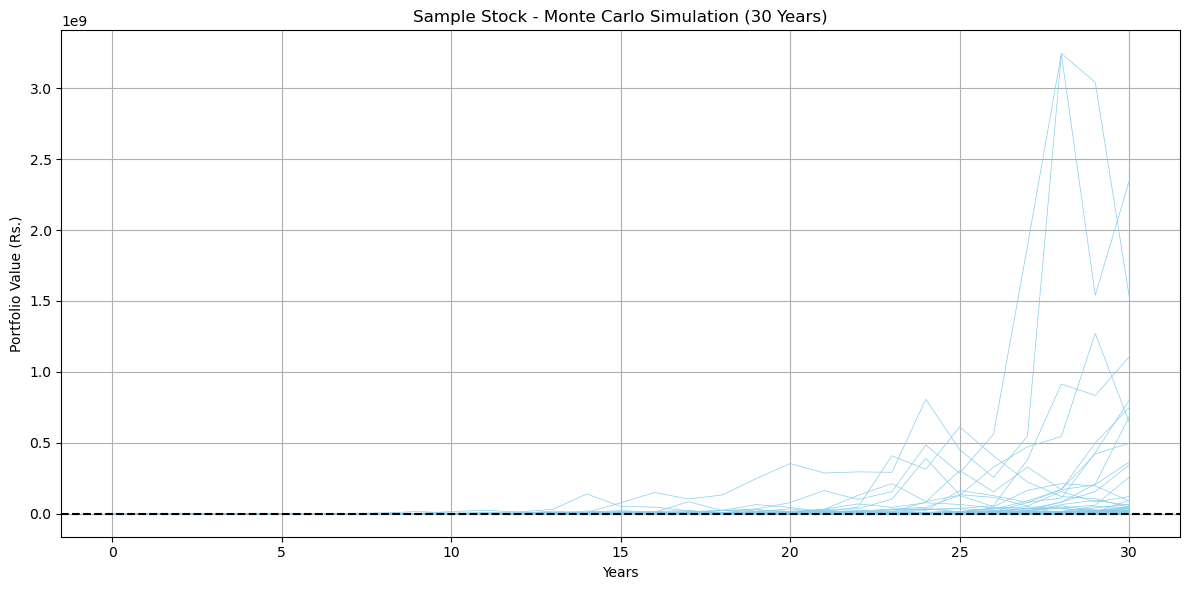

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
from datetime import datetime
from typing import Optional
from scipy.stats import trim_mean

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class MonteCarloSimulator:
    def __init__(
        self,
        ticker: str,
        years: int = 30,
        n_simulations: int = 1000,
        initial_investment: float = 10000.0,
        start_date: Optional[str] = "2010-01-01",
        end_date: Optional[str] = None
    ):
        self.ticker = ticker
        self.years = years
        self.n_simulations = n_simulations
        self.initial_investment = initial_investment
        self.start_date = start_date
        self.end_date = end_date or datetime.today().strftime('%Y-%m-%d')
        self.annual_return = None
        self.annual_volatility = None
        self.simulations = None

    def fetch_data(self):
        try:
            df = pd.read_csv('data/SAMPLE_STOCK.csv')
        except FileNotFoundError:
            raise FileNotFoundError("The file 'data/SAMPLE_STOCK.csv' was not found.")

        df['Date'] = pd.to_datetime(df['Date'], format='%b %d %Y', errors='coerce')
        df = df.dropna(subset=['Date'])

        df = df[(df['Date'] >= self.start_date) & (df['Date'] <= self.end_date)]
        if df.empty:
            raise ValueError("No data found in the specified date range.")

        df.sort_values('Date', inplace=True) 

        df.set_index('Date', inplace=True)

        if 'Adj Close' in df.columns:
            close_prices = df['Adj Close']
        elif 'Close' in df.columns:
            close_prices = df['Close']
        else:
            raise ValueError("Expected 'Close' or 'Adj Close' column not found.")

        logging.info(f"Loaded data from {close_prices.index.min().date()} to {close_prices.index.max().date()}")
        return close_prices


    def calculate_statistics(self, close_prices: pd.Series):
        logging.info("Calculating statistics from historical price data...")

        logging.info(f"Start price: {close_prices.iloc[0]:.2f}, End price: {close_prices.iloc[-1]:.2f}")

        daily_returns = close_prices.pct_change().dropna()
        mean_daily_return = daily_returns.mean()
        daily_volatility = daily_returns.std()

        logging.info(f"Mean Daily Return: {mean_daily_return:.6f}")
        logging.info(f"Daily Volatility: {daily_volatility:.6f}")

        # Annualize
        self.annual_return = (1 + mean_daily_return) ** 252 - 1
        self.annual_volatility = daily_volatility * np.sqrt(252)

        logging.info(f"Annual Return: {self.annual_return:.4f}")
        logging.info(f"Annual Volatility: {self.annual_volatility:.4f}")

    def run_simulation(self):
        logging.info("Running Monte Carlo simulations...")

        steps = self.years
        self.simulations = np.zeros((self.n_simulations, steps + 1))
        self.simulations[:, 0] = self.initial_investment

        for i in range(self.n_simulations):
            for t in range(1, steps + 1):
                rand = np.random.normal()
                growth_factor = (self.annual_return - 0.5 * self.annual_volatility ** 2) + self.annual_volatility * rand
                self.simulations[i, t] = self.simulations[i, t - 1] * np.exp(growth_factor)

        logging.info("Simulation completed.")

    def plot_simulations(self):
        if self.simulations is None:
            raise RuntimeError("Run simulations before plotting.")

        plt.figure(figsize=(12, 6))
        for i in range(min(100, self.simulations.shape[0])):
            plt.plot(self.simulations[i], color='skyblue', linewidth=0.5)

        plt.axhline(y=self.initial_investment, color='black', linestyle='--')
        plt.title(f"{self.ticker} - Monte Carlo Simulation ({self.years} Years)")
        plt.xlabel("Years")
        plt.ylabel("Portfolio Value (Rs.)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def summarize(self):
        final_values = self.simulations[:, -1]

        # Adjusting calculations to address skewness in the mean
        # Calculate profits for each simulation
        profits = final_values - self.initial_investment

        # Use trimmed mean to exclude extreme outliers
        trimmed_mean_profit = trim_mean(profits, proportiontocut=0.05)
        logging.info(f"Trimmed Mean Profit: {trimmed_mean_profit:,.2f}")

        # Update summary to use trimmed mean profit
        summary = {
            "Mean": trimmed_mean_profit + self.initial_investment,
            "Median": np.median(final_values),
            "5th Percentile": np.percentile(final_values, 5),
            "10th Percentile": np.percentile(final_values, 10),
            "25th Percentile": np.percentile(final_values, 25),
            "75th Percentile": np.percentile(final_values, 75),
            "95th Percentile": np.percentile(final_values, 95),
        }

        print("\nSummary of Final Portfolio Values:\n")
        print("+------------------+------------------+")
        print("| Metric           | Value (Rs.)      |")
        print("+------------------+------------------+")
        for k, v in summary.items():
            print(f"| {k:<16} | Rs.{v:,.2f}         |")
        return summary

    def run_full_pipeline(self):
        close_prices = self.fetch_data()
        self.calculate_statistics(close_prices)
        self.run_simulation()
        summary = self.summarize()
        self.plot_simulations()
        return summary


# Run full pipeline
if __name__ == "__main__":
    sim = MonteCarloSimulator(
        ticker="Sample Stock",
        years=30,
        n_simulations=1000,
        initial_investment=10000.0,
        start_date="1996-01-01"
    )
    sim.run_full_pipeline()


# Summary of Final Portfolio Values

The Monte Carlo simulation provides insights into the potential future performance of the portfolio over the investment period of 30 years. Below is the summary of the final portfolio values in relation to the initial investment amount of Rs.10,000:

+------------------+------------------+
| Metric           | Value (Rs.)      |
+------------------+------------------+
| Mean             | Rs.27,803,443.26         |
| Median           | Rs.602,489.83         |
| 5th Percentile   | Rs.293.20         |
| 10th Percentile  | Rs.1,917.66         |
| 25th Percentile  | Rs.25,858.06         |
| 75th Percentile  | Rs.11,646,385.09         |
| 95th Percentile  | Rs.745,396,984.99         |
+------------------+------------------+

### Interpretation
- **Mean**: The average portfolio value at the end of the 30-year investment period is Rs.27,803,443.26.
- **Median**: Half of the simulations resulted in a portfolio value above Rs.602,489.83 and half below.
- **5th Percentile**: In the worst-case scenario, the portfolio value could drop to Rs.293.20.
- **10th Percentile**: The portfolio value could drop to Rs.1,917.66 in a less extreme scenario.
- **25th Percentile**: The portfolio value could drop to Rs.25,858.06 in a moderate scenario.
- **75th Percentile**: The portfolio value could grow to Rs.11,646,385.09 in a favorable scenario.
- **95th Percentile**: In the best-case scenario, the portfolio value could grow to Rs.745,396,984.99.

### Profitability Analysis
- Based on the **mean** portfolio value (Rs.27,803,443.26), the investment could result in significant growth compared to the initial investment of Rs.10,000.
- The **median** portfolio value (Rs.602,489.83) indicates substantial growth.
- The **5th Percentile** shows a worst-case scenario where the portfolio value could drop to Rs.293.20.
- The **10th Percentile** shows a less extreme scenario where the portfolio value could drop to Rs.1,917.66.
- The **25th Percentile** shows a moderate scenario where the portfolio value could drop to Rs.25,858.06.
- The **75th Percentile** shows a favorable scenario where the portfolio value could grow to Rs.11,646,385.09.
- The **95th Percentile** shows a best-case scenario where the portfolio value could grow to Rs.745,396,984.99.

### Conclusion
Based on the simulation results, the investment has the potential for significant growth over the 30-year period. This highlights the importance of reviewing the assumptions and parameters used in the simulation.